In [1]:
# 全局设置
import datetime as dt

import numpy as np
import pandas as pd

import QuantStudio.api as QS
fd = QS.FactorDB.FactorTools

HDB = QS.FactorDB.HDF5DB(config_file="../config/HDF5DBConfig.json").connect();

# 收益率预测因子测试

==========历史回测==========
1. 初始化
耗时 : 0.53
2. 循环计算


100% (566 of 566) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


耗时 : 59.33
3. 结果生成
耗时 : 0.21
总耗时 : 60.07



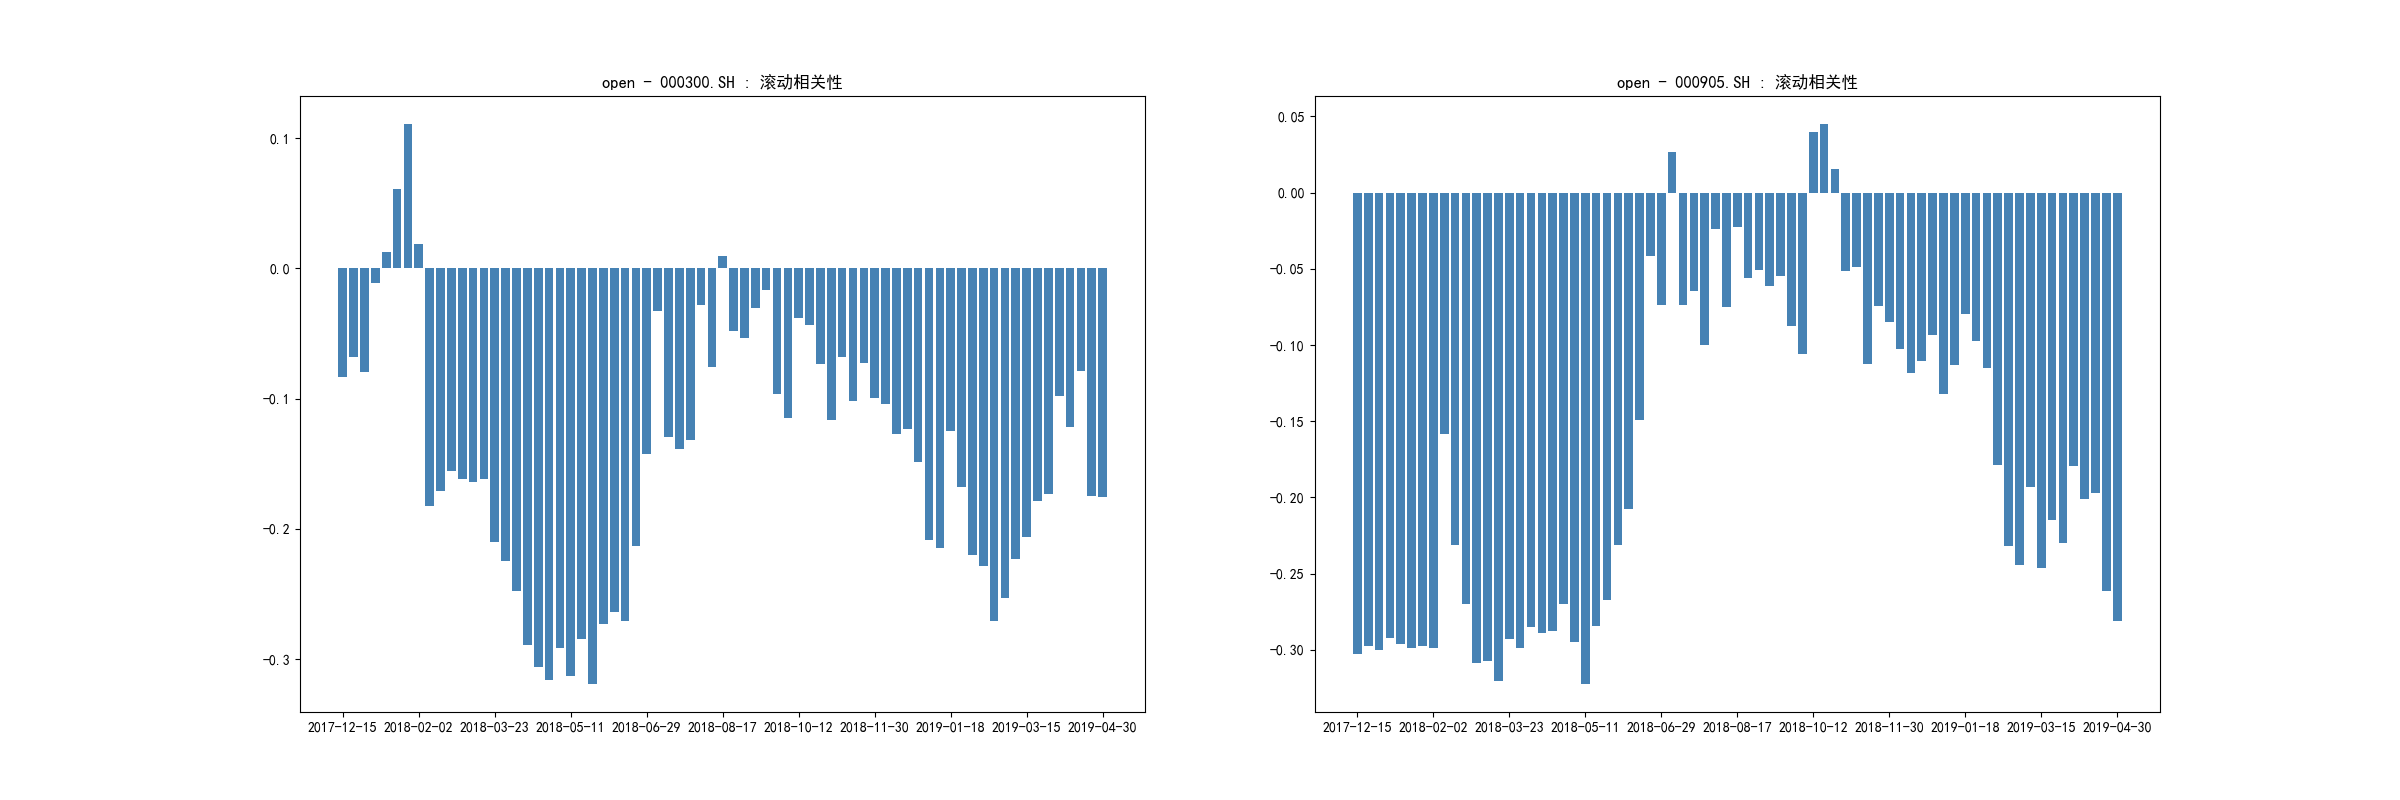
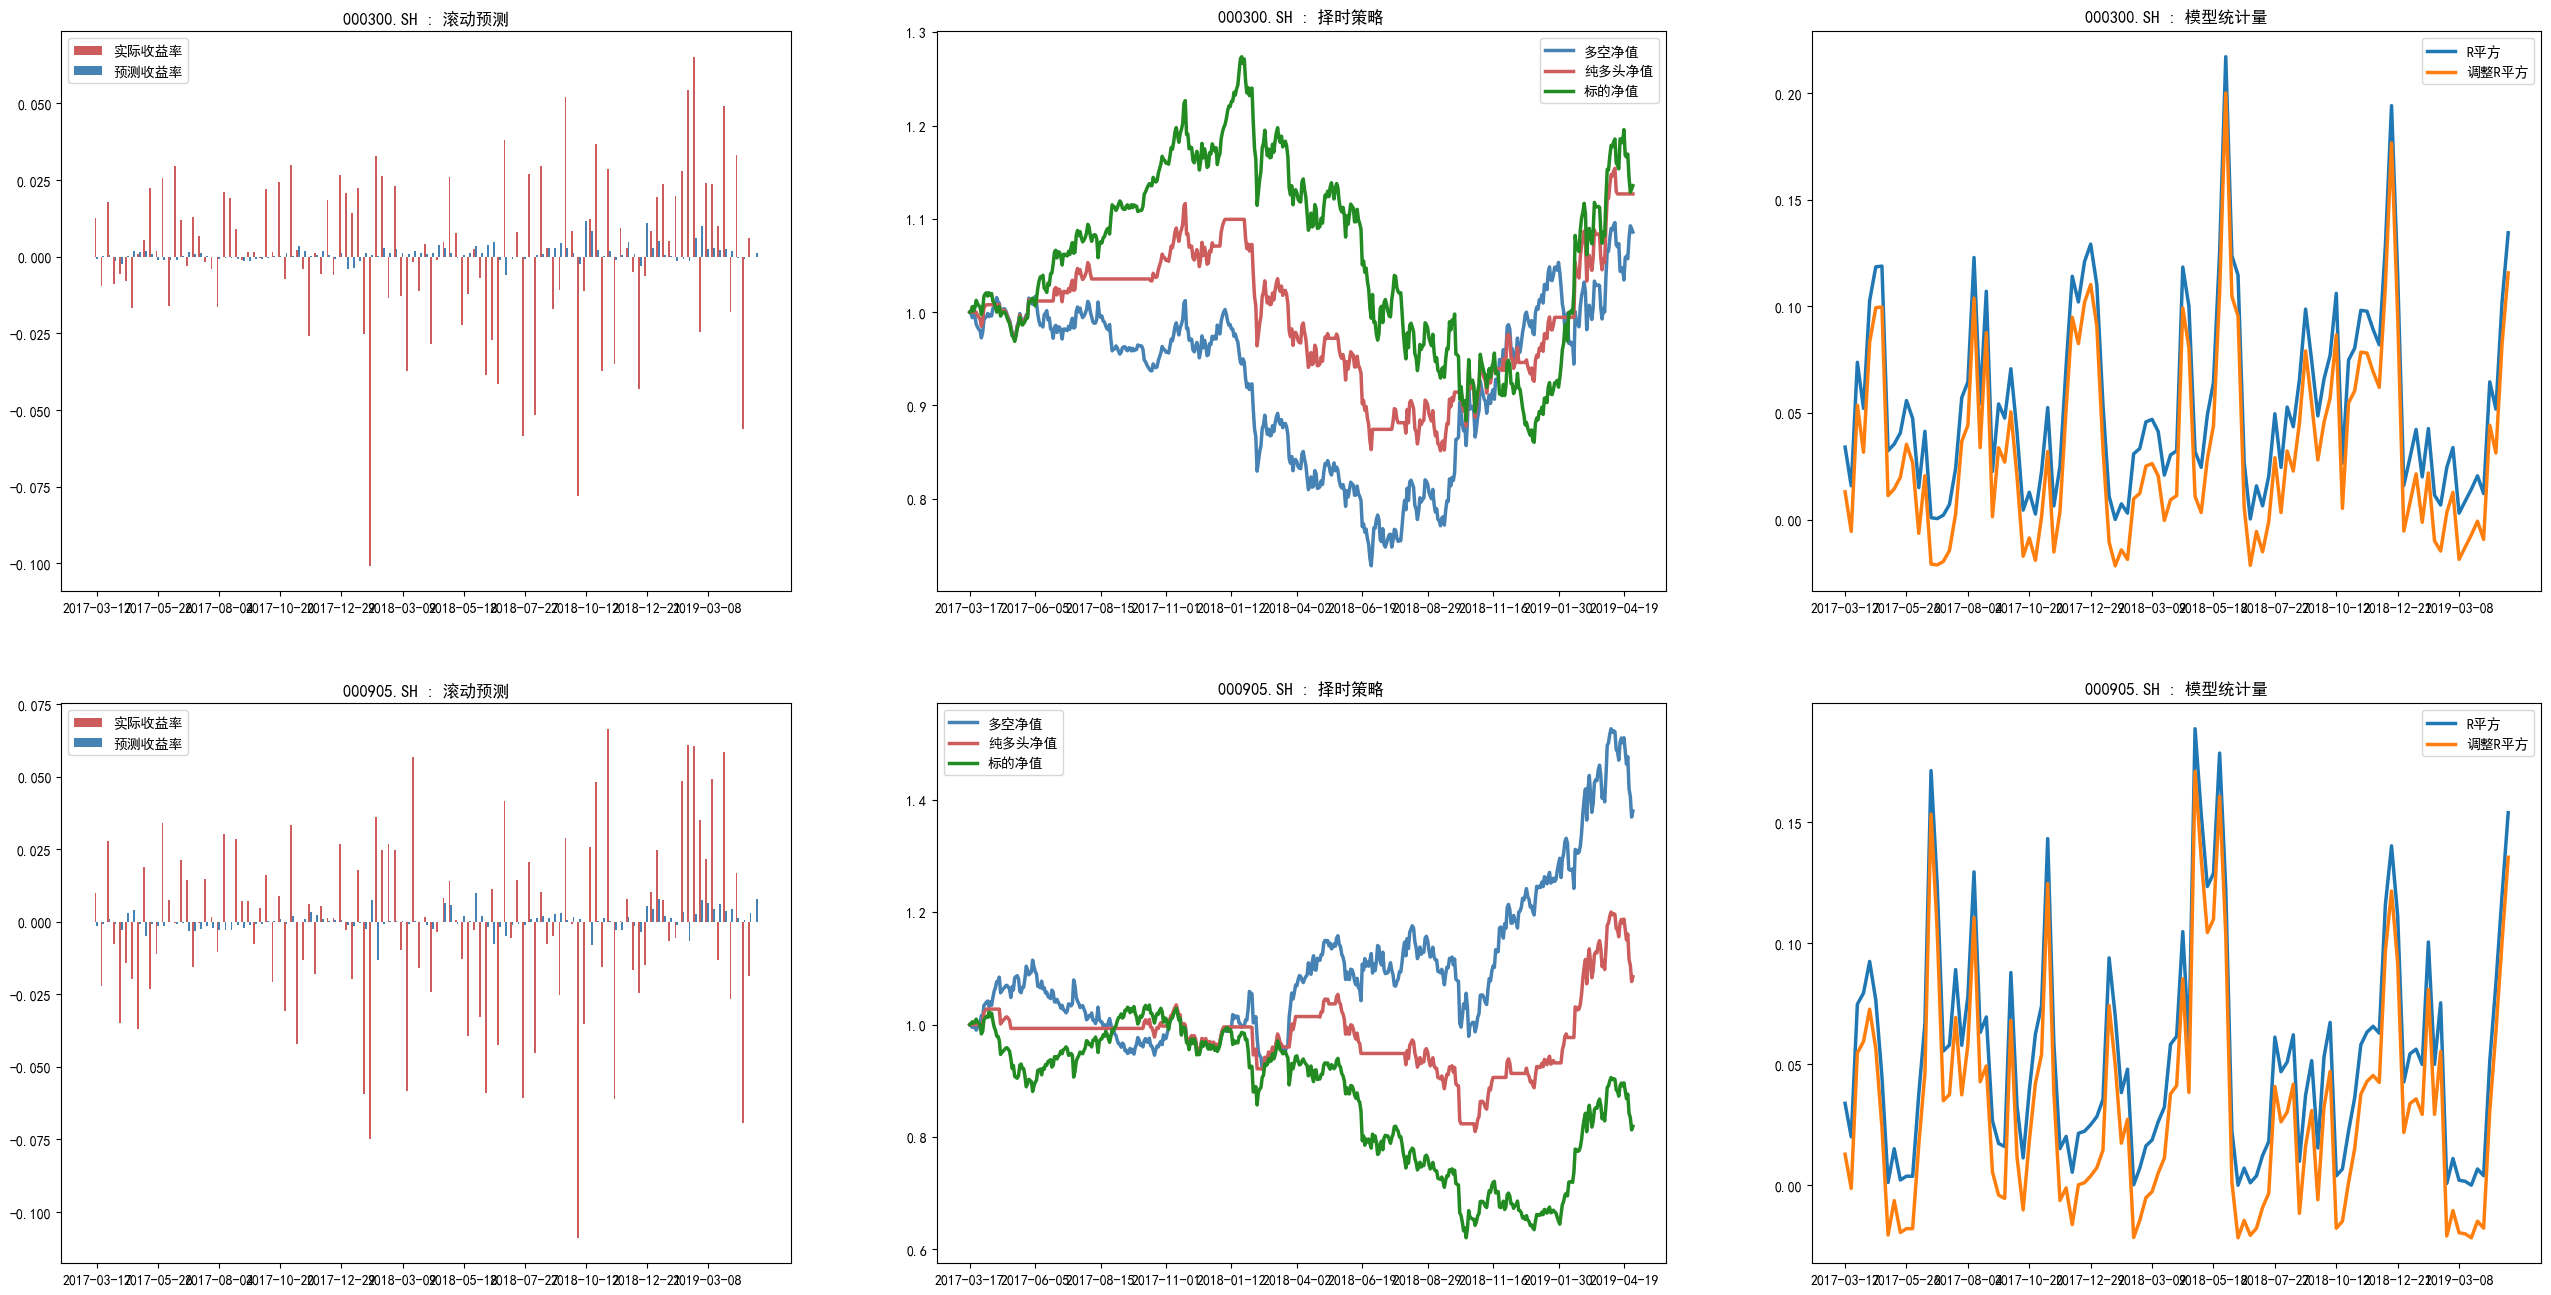

In [2]:
# 时序因子测试
StartDT, EndDT = dt.datetime(2017, 1, 1), dt.datetime(2019, 4, 30)

FT = HDB.getTable("index_cn_day_bar")
DTs = FT.getDateTime(start_dt=StartDT, end_dt=EndDT)
IDs = ["000300.SH", "000905.SH"]

# 再平衡时点序列
#BalanceDTs = DTs
#BalanceDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)# 月末
BalanceDTs = QS.Tools.DateTime.getWeekLastDateTime(DTs)# 周末
# BalanceDTs = QS.Tools.DateTime.getQuarterLastDateTime(DTs)# 季末
# BalanceDTs = QS.Tools.DateTime.getYearLastDateTime(DTs)# 年末

# 创建自定义因子表
CFT = QS.FactorDB.CustomFT("CFT")
CFT.addFactors(factor_table=HDB.getTable("index_cn_day_bar"), factor_names=["open", "low", "close"], args={})
CFT.setDateTime(DTs)
CFT.setID(IDs)

# 择时因子
TestFactors = ["open"]

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# --------因子测试模块--------
# 相关性测试
iModule = QS.BackTest.TimeSeriesFactor.TimeSeriesCorrelation(factor_table=CFT)
iModule.Args["测试因子"] = TestFactors
iModule.Args["价格因子"] = "close"
iModule.Args["收益率类型"] = "简单收益率"
iModule.Args["预测期数"] = 1
iModule.Args["滞后期数"] = 0
iModule.Args["计算时点"] = BalanceDTs
iModule.Args["相关性算法"] = "pearson"
iModule.Args["统计窗口"] = 48
iModule.Args["最小统计窗口"] = 48
Model.Modules.append(iModule)

# 时序回归测试
iModule = QS.BackTest.TimeSeriesFactor.OLS(factor_table=CFT)
iModule.Args["测试因子"] = TestFactors
iModule.Args["价格因子"] = "close"
iModule.Args["收益率类型"] = "简单收益率"
iModule.Args["预测期数"] = 1
iModule.Args["滞后期数"] = 0
iModule.Args["计算时点"] = BalanceDTs
iModule.Args["统计窗口"] = 48
iModule.Args["最小统计窗口"] = 48
iModule.Args["模型参数"] = {"常数项": True}
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs)

# 查看结果
display(Model)

# 目标仓位择时信号测试

==========历史回测==========
1. 初始化
耗时 : 0.52
2. 循环计算


100% (566 of 566) |######################| Elapsed Time: 0:00:55 Time:  0:00:55


耗时 : 63.57
3. 结果生成
耗时 : 0.23
总耗时 : 64.32



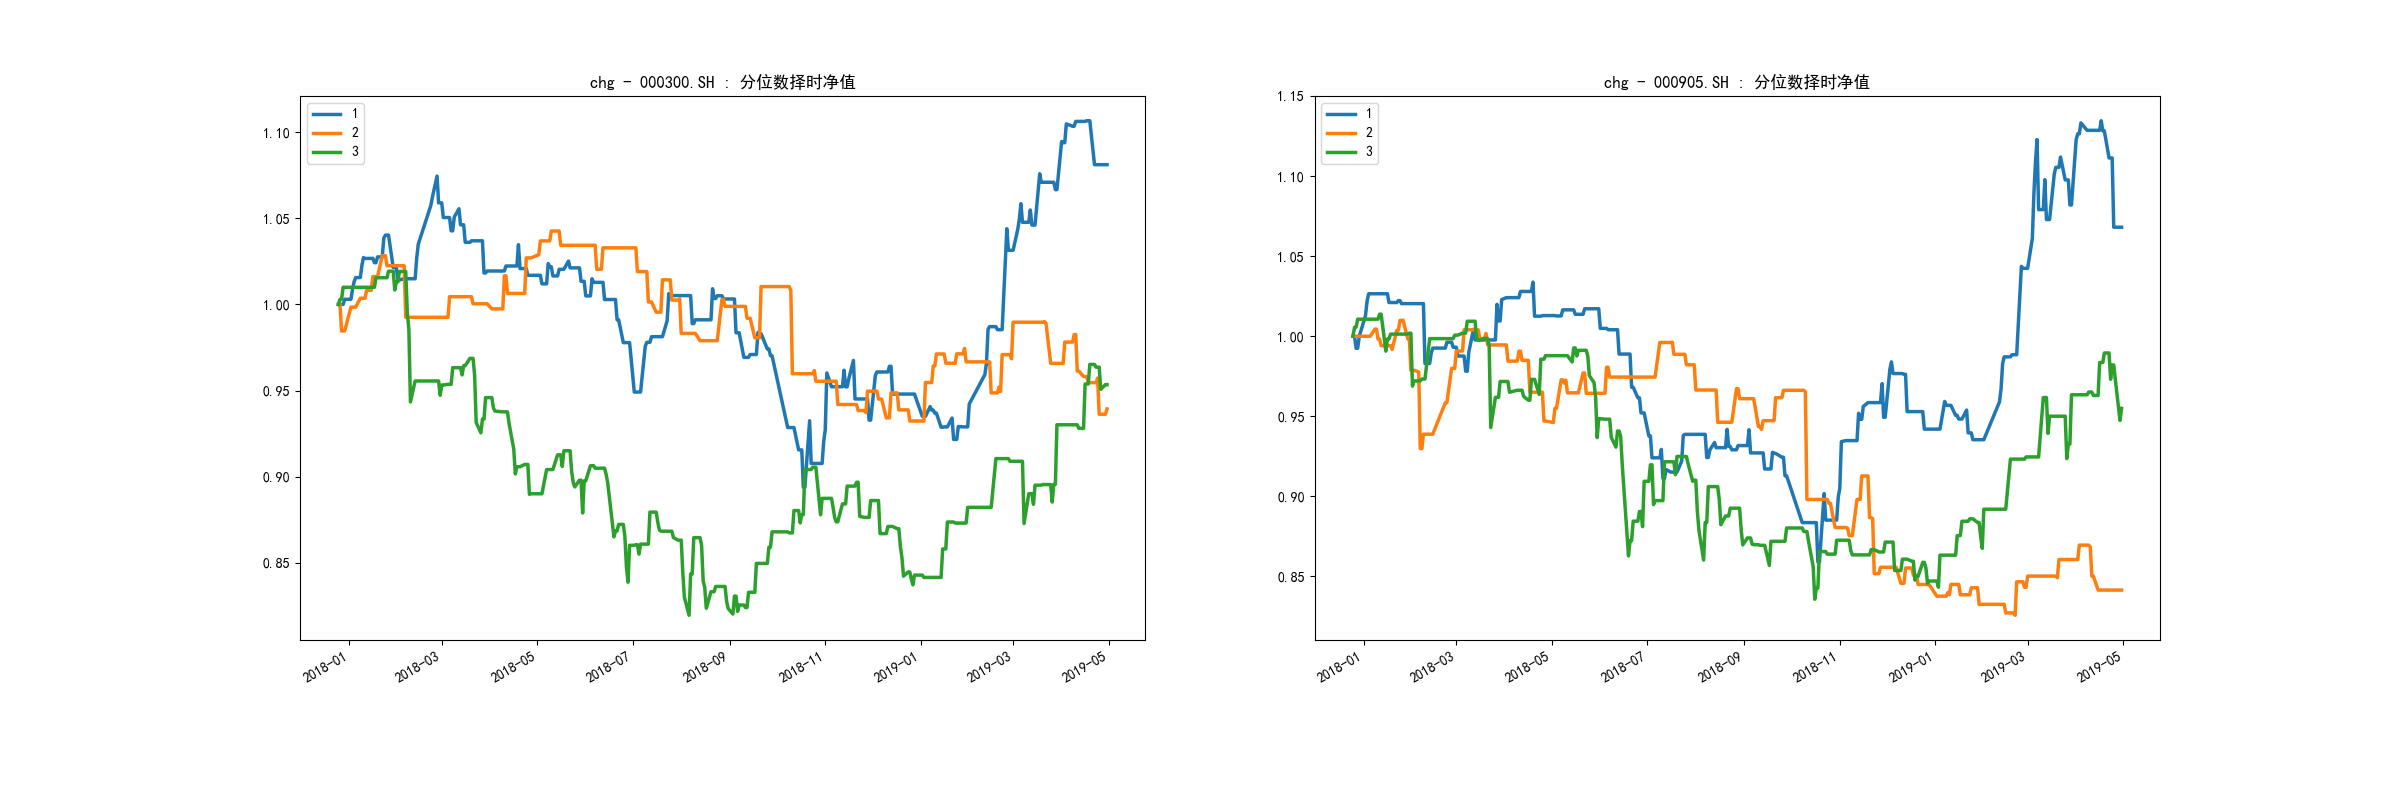
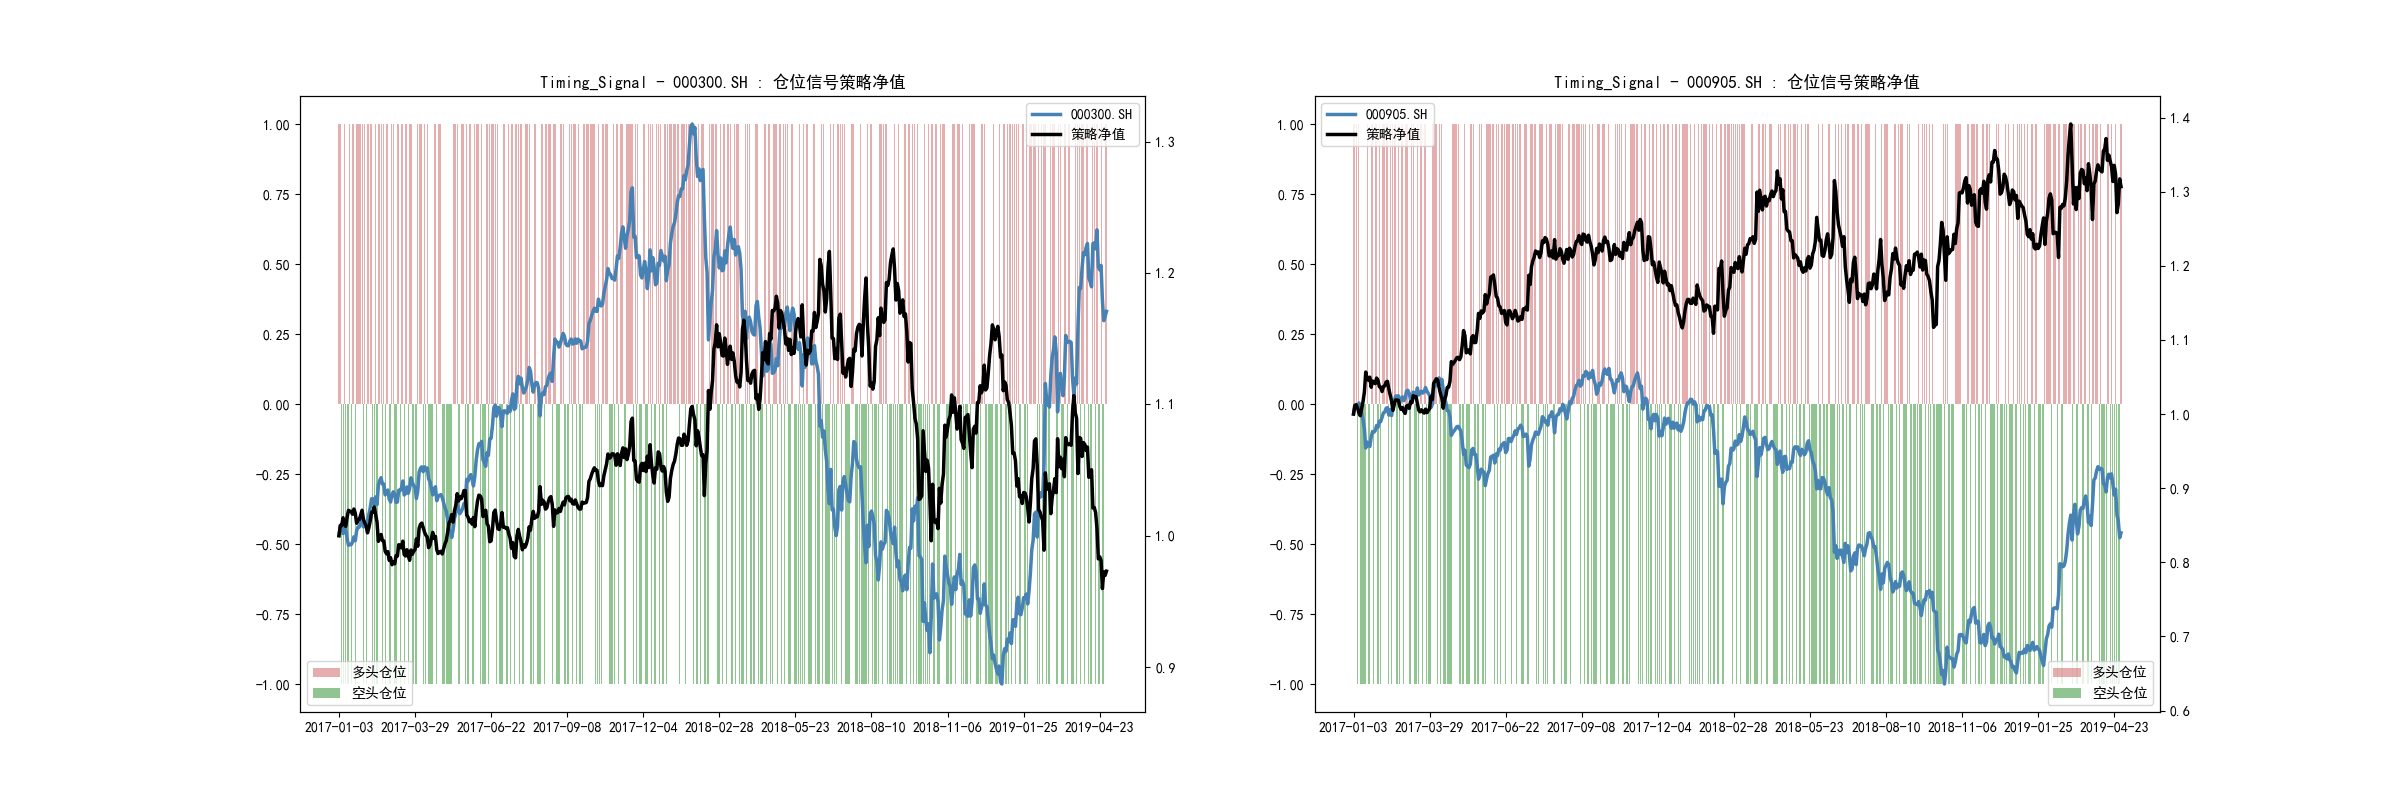

In [2]:
# 时序因子测试
StartDT, EndDT = dt.datetime(2017, 1, 1), dt.datetime(2019, 4, 30)

FT = HDB.getTable("index_cn_day_bar")
DTs = FT.getDateTime(ifactor_name="close", start_dt=StartDT, end_dt=EndDT)
IDs = ["000300.SH", "000905.SH"]

# 再平衡时点序列
BalanceDTs = DTs
#BalanceDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)# 月末
# BalanceDTs = QS.Tools.DateTime.getWeekLastDateTime(DTs)# 周末
# BalanceDTs = QS.Tools.DateTime.getQuarterLastDateTime(DTs)# 季末
# BalanceDTs = QS.Tools.DateTime.getYearLastDateTime(DTs)# 年末

# 创建自定义因子表
CFT = QS.FactorDB.CustomFT("CFT")
CFT.addFactors(factor_list=[HDB.getTable("index_cn_day_bar").getFactor("close")])

# 目标仓位择时信号
Factors = []
FT = HDB.getTable("index_cn_day_bar")
TargetFactor = FT.getFactor("chg")
Factors.append(TargetFactor)
Signal = fd.where(1, TargetFactor>0, np.nan)
Signal = fd.where(-1, TargetFactor<0, Signal, factor_name="Timing_Signal")
Factors.append(Signal)

CFT.addFactors(factor_list=Factors)
CFT.setDateTime(DTs)
CFT.setID(IDs)

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# --------因子测试模块--------
# 分位数择时策略测试
iModule = QS.BackTest.TimeSeriesFactor.QuantileTiming(factor_table=CFT)
iModule.Args["测试因子"] = ["chg"]
iModule.Args["排序方向"] = {"chg": "降序"}
iModule.Args["价格因子"] = "close"
iModule.Args["计算时点"] = BalanceDTs
iModule.Args["统计窗口"] = 600
iModule.Args["最小统计窗口"] = 240
iModule.Args["分组数"] = 3
Model.Modules.append(iModule)

# 目标仓位信号测试
iModule = QS.BackTest.TimeSeriesFactor.TargetPositionSignal(factor_table=CFT)
iModule.Args["测试因子"] = ["Timing_Signal"]
iModule.Args["价格因子"] = "close"
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs)

# 查看结果
display(Model)

# 交易型择时信号测试

==========历史回测==========
1. 初始化
耗时 : 0.50
2. 循环计算


100% (566 of 566) |######################| Elapsed Time: 0:00:33 Time:  0:00:33


耗时 : 41.28
3. 结果生成
耗时 : 0.26
总耗时 : 42.05


Statistics,总计,000300.SH,000905.SH
交易次数,726,370,356
盈利次数,271,139,132
亏损次数,455,231,224
总盈亏,0.97,0.12,0.85
平均收益率,0.13%,0.03%,0.24%
年化收益率,10.37%,2.47%,18.45%
平均盈利率,2.19%,1.77%,2.64%
平均亏损率,1.09%,1.01%,1.18%
单次最大盈利率,11.04%,6.93%,11.04%
单次最大亏损率,4.30%,4.30%,4.02%

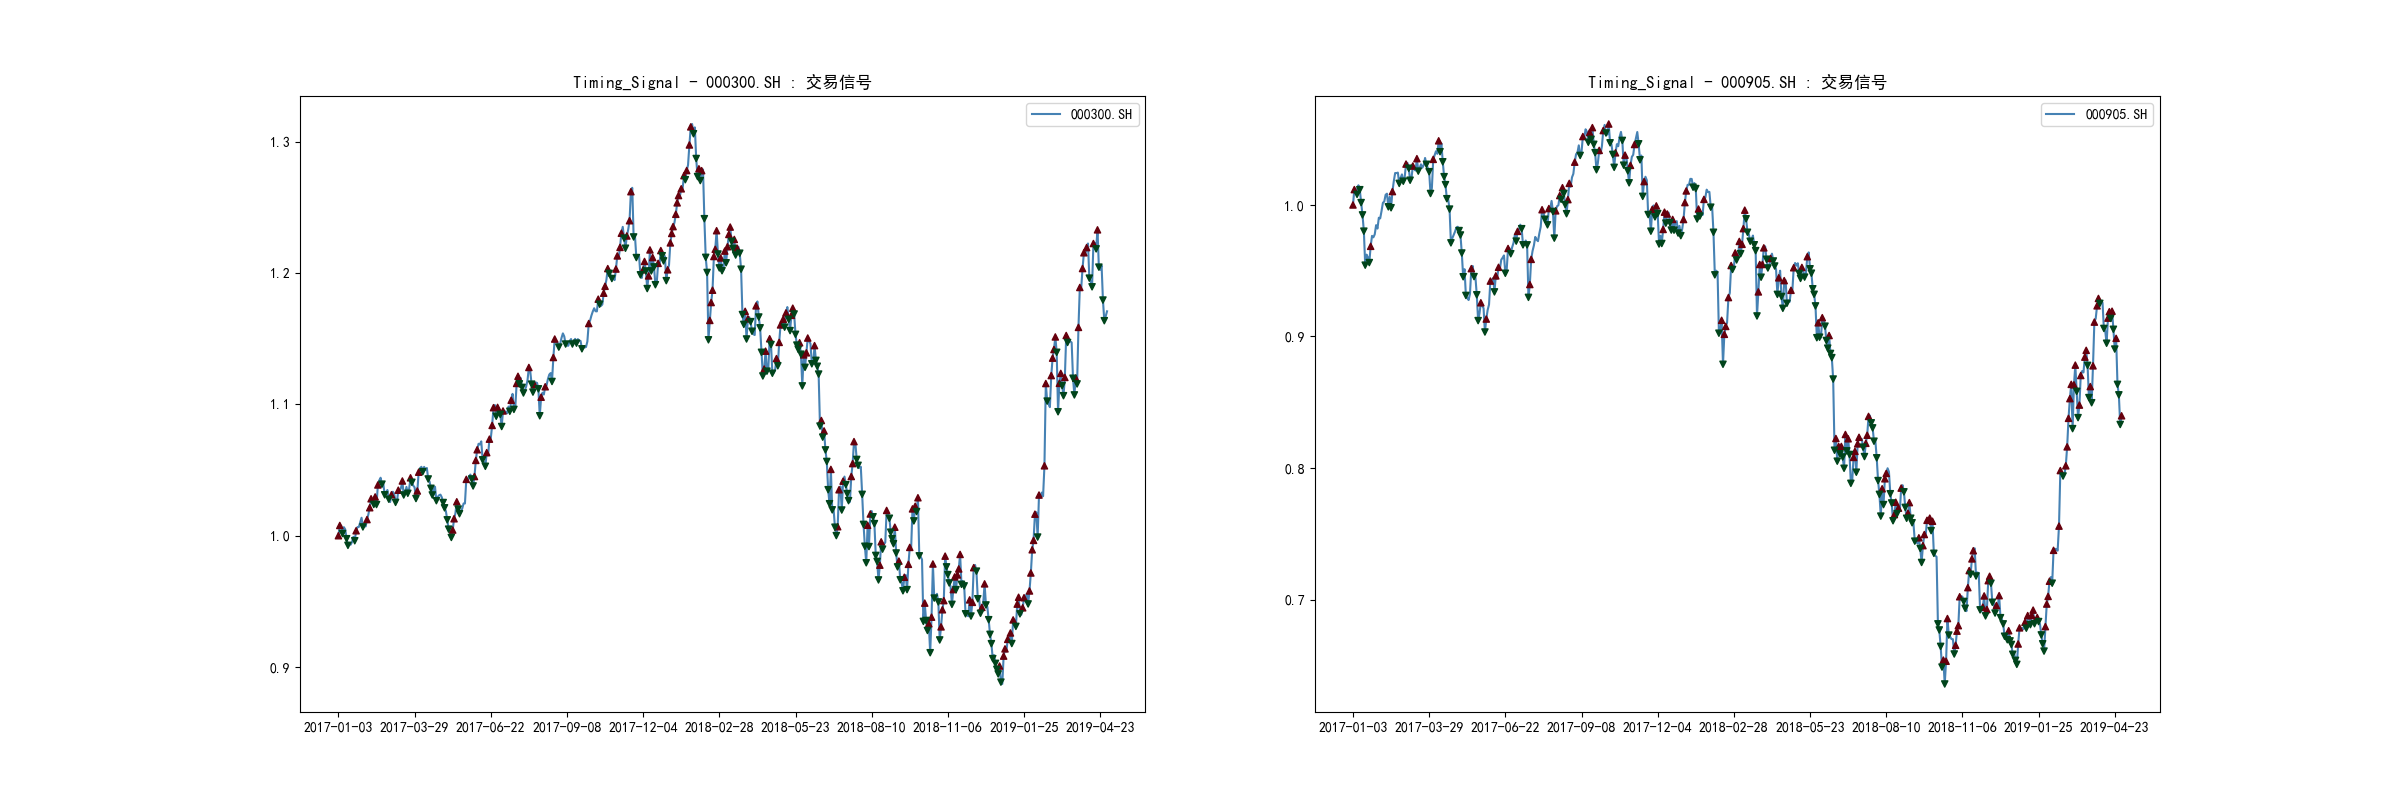

In [3]:
# 时序因子测试
# 参数设置
StartDT = dt.datetime(2014, 1, 1)# 数据开始时点
EndDT = dt.datetime(2019, 4, 30)# 数据截止时点
TestStartDT = dt.datetime(2017, 1, 1)# 测试开始时点
TestEndDT = EndDT# 测试结束时点

FT = HDB.getTable("index_cn_day_bar")
DTs = FT.getDateTime(start_dt=StartDT, end_dt=EndDT)
TestDTs = FT.getDateTime(start_dt=TestStartDT, end_dt=TestEndDT)
IDs = ["000300.SH", "000905.SH"]

# 再平衡时点序列
BalanceDTs = TestDTs
#BalanceDTs = QS.Tools.DateTime.getMonthLastDateTime(TestDTs)# 月末
# BalanceDTs = QS.Tools.DateTime.getWeekLastDateTime(TestDTs)# 周末
# BalanceDTs = QS.Tools.DateTime.getQuarterLastDateTime(TestDTs)# 季末
# BalanceDTs = QS.Tools.DateTime.getYearLastDateTime(TestDTs)# 年末

# 创建自定义因子表
CFT = QS.FactorDB.CustomFT("CFT")
FT = HDB.getTable("index_cn_day_bar")
Close = FT.getFactor("close")
CFT.addFactors(factor_list=[Close])

# 交易型择时信号 : EP
Factors = []
FT = HDB.getTable("index_cn_day_bar")
TargetFactor = FT.getFactor("chg")
Signal = fd.where(1, TargetFactor>fd.rolling_quantile(TargetFactor, 720, 2/3, min_periods=240), np.nan)
Signal = fd.where(-1, TargetFactor<fd.rolling_quantile(TargetFactor, 720, 1/3, min_periods=240), Signal, factor_name="Timing_Signal")
Factors.append(Signal)

CFT.addFactors(factor_list=Factors)
CFT.setDateTime(DTs)
CFT.setID(IDs)

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# --------因子测试模块--------
# 交易型择时信号测试
iModule = QS.BackTest.TimeSeriesFactor.TradeSignal(factor_table=CFT)
iModule.Args["测试因子"] = ["Timing_Signal"]
iModule.Args["价格因子"] = "close"
iModule.Args["计算时点"] = BalanceDTs
iModule.Args["结束清仓"] = True
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=TestDTs)

# 查看结果
display(Model)